In [1]:
# Importando dependencias

#! pip install pyadi-iio
#! pip install matplotlib
#! pip install scikit-dsp-comm
#! pip install scikit-commpy

import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft
import scipy.fftpack
import adi

In [2]:
# Función para graficar señales en el tiempo
def plot_signal(title, xlabel, ylabel, time, *signals, ticks=False, cont=False):
    fig, ax = plt.subplots(figsize=(15, 4))
    # El fondo del gráfico es de color negro
    fig.patch.set_facecolor('black')
    # El título del gráfico, se escribe en blanco para contrastar al fondo negro
    plt.title(title, fontdict={'color':'white', 'weight':'bold'})
    # El fondo de los ejes también es negro
    ax.set_facecolor('black')
    # Se pueden pasar multiples señales para que se impriman superpuestas
    # Todas las señales deben estar acotadas en el mismo periodo de tiempo
    for i in range(len(signals)):
        if cont:
            # gráfico continuo
            plt.plot(time, signals[i])
        else:
            # gráfico discreto
            plt.stem(time, signals[i], basefmt=" ")
    # Etiquetas de los ejes x e y
    plt.xlabel(xlabel, fontdict={'color':'white', 'weight':'bold'})
    plt.ylabel(ylabel, fontdict={'color':'white', 'weight':'bold'})
    if not ticks:
        # Si _ticks es falso solo se agregará en valor inicial y final del tiempo 
        plt.xticks([time[0], time[-1]], visible=True, rotation="horizontal")
    # Las escalas se escriben en blanco
    ax.tick_params(axis='both', which='major', labelsize=10, colors='white')
    plt.grid()
    plt.show()

# Función para graficar histogramas 
def plot_histogram(title, is_normalized, signal):
    # El estilo del gráfico coincide con el gráfico en el tiempo
    fig, ax = plt.subplots(figsize=(15, 4))
    fig.patch.set_facecolor('black')
    plt.title(title, fontdict={'color':'white', 'weight':'bold'})
    ax.set_facecolor('black')
    plt.hist(signal, bins=50)
    if is_normalized:
        # Se normalizan los valores del histograma
        locs, _ = plt.yticks()
        plt.yticks(locs, np.round(locs/len(signal), 3))
    ax.tick_params(axis='both', which='major', labelsize=10, colors='white')
    plt.grid()
    plt.show()


# Función para graficar espectrogramas (Variación de frecuencia en el tiempo)
def plot_spectrogram(title, fs, symbol, n=128):
    # stft es una transformada de Fourier que se realiza en tramos pequeños
    f, t_stft, zxx = stft(symbol, fs=fs, nperseg=16, return_onesided=False, nfft=n)

    f = np.fft.fftshift(f)  # Centrar las frecuencias
    zxx = np.fft.fftshift(zxx, axes=0)  # Ajustar el espectro a frecuencias centradas

    plt.figure(figsize=(10, 6))
    plt.pcolormesh(t_stft, f, np.abs(zxx), shading='gouraud')
    plt.title(title, fontdict={'color':'black', 'weight':'bold'})
    plt.ylabel('Frecuencia [Hz]')
    plt.xlabel('Tiempo [seg]')
    plt.colorbar(label='Magnitud')
    plt.ylim(-fs/2, fs/2)
    plt.show()

def plot_ber(title, snr, ber):
    fig, ax = plt.subplots(figsize=(10, 6))
    fig.patch.set_facecolor('black')
    ax.set_facecolor('black')
    
    # Graficar datos
    ax.semilogy(snr, ber, marker='s', color='blue', linestyle='-',
                markerfacecolor='black', markeredgewidth=1.5)
        
    # Configurar etiquetas y título
    ax.set_xlabel('SNR', fontdict={'color': 'white', 'weight': 'bold'})
    ax.set_ylabel('BER', fontdict={'color': 'white', 'weight': 'bold'})
    ax.set_title(title, fontdict={'color': 'white', 'weight': 'bold'})
    
    # Configurar cuadrícula
    ax.grid(True, which="both", linestyle="--", linewidth=0.5, color='white')
    
    # Configurar ticks en el eje Y
    ax.set_yticks([1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
    ax.set_yticklabels(["$10^{-6}$", "$10^{-5}$", "$10^{-4}$", "$10^{-3}$", "$10^{-2}$", "$10^{-1}$"], color='white')
    
    # Configurar ticks en el eje X
    ax.set_xticks(snr)
    ax.tick_params(axis='x', colors='white')  # Colores de los ticks en X
    ax.tick_params(axis='y', colors='white')  # Colores de los ticks en Y
    
    # Ajustar límites de los ejes
    ax.set_ylim(1e-6, 1e-1)
    ax.set_xlim(min(snr), max(snr))
    
    # Mostrar gráfico
    plt.show()

# Frequency Shift Chirp Modulation (FSCM):

FSCM es uno de los nombres dados a la modulación utilizada por los sistemas LoRa para transmisión de señales en grandes áreas con bajo consumo de energía, específicamente FSCM es el nombre asignado por *Lorenzo Vangelista* en su documento *Frequency Shift Chirp Modulation: The LoRa Modulation*, y es su descripción de esta modulación la que buscaremos aplicar en este trabajo.

## Procedimiento

Siguiendo el procedimiento presentado por Vangelista iniciaremos por introducir una fuente de hipótesis binarias con SF bits, luego las codificaremos a palabras código decimales con el procedimiento típico de conversión binaria a decimal, verificando la uniformidad de la fuente en el proceso. 

Ya con nuestras hipótesis codificadas, realizaremos la modulación y la generación de paquetes, en un principío centrándonos únicamente en los datos y luego agregando un preámbulo simple, típico de sistemas de comunicación inalámbricos. La transmisión y recepción las realizaremos de forma teórica, simulando el medio por código, y luego brindaremos un código práctico para su aplicación en SDR. 

Por último realizaremos la demodulación computacionalmente eficiente descrita por Vangelista y generaremos gráficos que nos permitan observar la resistencia del sistema contra diferentes tipos de ruido.

## Generador de hipótesis

Antes de realizar la modulación es necesario generar las hipótesis que deseamos transmitir. Como se mencionó previamente, consideraremos una fuente que produzca palabras **w** en código binario con n bits.

El código a continuación generará hipótesis aleatorias produciendo cada bit con una distribución uniforme entre 0 y 1.

In [3]:
# Genera un hipótesis binaria de 'nbits' bits
def hypothesis_source(nbits):
    return np.random.randint(0, 2, nbits)

W = hypothesis_source(4)
print("Hipótesis aleatoria: " + str(W))

Hipótesis aleatoria: [0 0 1 1]


Rápidamente, realizaremos una simple demostración de la uniformidad de los bits producidos por la fuente con un histograma que nos permita observar la distribución de los bits producidos en una simple simulación de monte carlo.

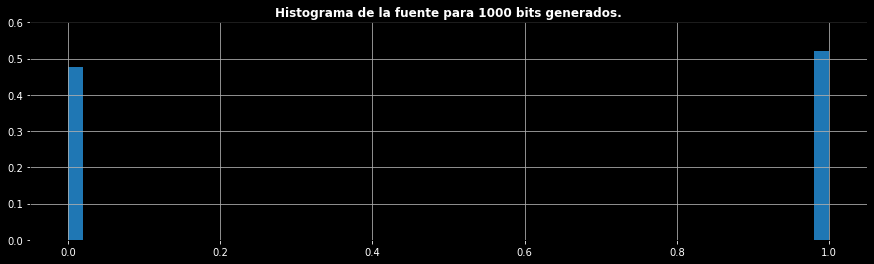

In [4]:
Iteraciones = 1000
plot_histogram("Histograma de la fuente para " + str(Iteraciones) + " bits generados.", True, hypothesis_source(Iteraciones))

## Encoder

Para codificar las hipótesis se utiliza el polinomio de numeración, que nos permitirá convertir nuestras palabras en binario a códigos decimales. La fórmula se describe como:

$$s(nT_s) = \sum_{h=0}^{SF}w(nT_s)_h2^h$$

Donde $T_s$ es el periodo que transcurre entre un símbolo y el siguiente en caso de transmitirse múltiples símbolos, $n$ es el índice del símbolo en particular y $SF$ el número de bits por palabra código, en caso de que $w$ tenga un número de bits distinto de $SF$ se lo completaría con ceros a la izquierda que no afectarían al resultado. Luego $w(nT_s)$ es la hipótesis como se la describió previamente, y $s(nT_s)$ será la palabra código o símbolo correspondiente a dicha hipótesis.

In [5]:
# Codifica un único símbolo binario con el polinomio de numeración 
def encoder(hypothesis):
    return np.sum([hypothesis[len(hypothesis)-1-i]*2**i for i in range(len(hypothesis))])

Symbol = encoder(W)
print("La hipótesis W = " + str(W) + " se codifico a " + str(Symbol))

La hipótesis W = [0 0 1 1] se codifico a 3


De la misma forma que se hizo con los bits de la hipótesis, nos puede interesar demostrar que los símbolos también serán distribuidos uniformemente. 

La hipótesis **w** que se generó a partir de bits uniformemente distribuidos, será también uniformemente distribuida, ya que es el producto de una combinación lineal de valores uniformemente distribuidos e independientes entre sí, con lo que la probabilidad de obtener un valor específico de **w** será:

$$P(w=k)=\prod_{i=0}^{SF}P(b_i)$$

Dado que cada bit es equiprobable entre 2 valores el resultado será:

$$P(w=k)=\prod_{i=0}^{SF}0.5=\frac{1}{2^{SF}}$$

Y habiendo $2^{SF}$ posibles valores para nuestra hipótesis, estas serán equiprobables. Luego nuestra palabra código es producida nuevamente como una combinación lineal de los mismos bits.

Para demostrar este punto se realiza una simple simulación de monte carlo, generando una cantidad considerable de hipótesis, codificándolas y luego armando un histograma, en el que se espera observar que todas las posibles hipótesis se generan aproximadamente el mismo número de veces.


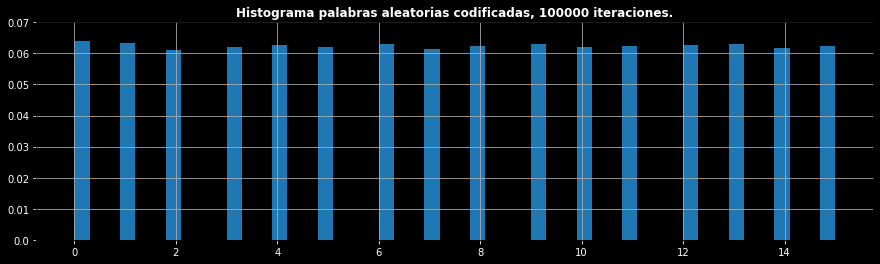

In [6]:
Iteraciones = 100000
Hypothesises = np.array([hypothesis_source(4) for _ in range(Iteraciones)])
Codes = [encoder(Hypothesises[i]) for i in range(Hypothesises.shape[0])]
plot_histogram("Histograma palabras aleatorias codificadas, " + str(Iteraciones) + " iteraciones.", True, Codes)

Por último debemos tener en cuenta que las hipótesis no serán siempre generadas con un valor exactamente igual a $SF$, sino que quizas querramos transmitir mensajes de tamaños variables. Para estos casos deberemos completar la hipótesis con ceros a la izquerda para que el número de bits sea múltiplo del $SF$ deseado y así poder codificar el mensaje como un mensaje de $n$ códigos de $SF$ bits. 

In [7]:
Hypothesis = hypothesis_source(54)

# Codifica un mensaje binario en palabras de 'sf' bits usando el polinomio de numeración
def encode_full_message(hypothesis, sf):
    s = np.array([], dtype=int)
    last = int(len(hypothesis)/sf)
    for i in range(last):
        # Se codifican las palabras de derecha a izquierda
        to_code = hypothesis[len(hypothesis)-(i+1)*sf:len(hypothesis)-i*sf]
        # La nueva palabra se coloca a la izquierda del mensaje codificado
        s = np.append(int(encoder(to_code)), s)
    if len(hypothesis)%sf != 0:
        # Si el mensaje no es múltiplo de sf, la última palabra se rellena con ceros a la izquierda
        to_code = np.append(np.zeros(sf - int(len(hypothesis)%sf)), hypothesis[:int(len(hypothesis)%sf)])
        s = np.append(int(encoder(to_code)), s)
    return s

Message = encode_full_message(Hypothesis, 4)

print('Hipótesis generada: ' + str(Hypothesis))
print('Mensaje codificado: ' + str(Message))

Hipótesis generada: [1 0 0 1 0 1 0 1 0 0 1 0 0 1 1 1 0 1 0 1 1 0 1 0 0 1 0 0 0 1 0 1 1 1 0 1 1
 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 1 0]
Mensaje codificado: [ 2  5  4  9 13  6  9  1  7  6 12  6  6  2]


## Modulación

### ¿Qué es un chirp?

Como el nombre lo indica la modulación FSCM consiste en la transmisión de símbolos en forma de **chirps** defasados una frecuencia $\theta$ para cada símbolo. A estas alturas nos podemos preguntar entonces ¿Qué es un chirp?

Un chirp o *sweep signal* es una señal sinusoidal que inicia con una frecuencia inicial $f_i$ la cual aumenta o desciende linealmente en el tiempo hasta llegar a una frecuencia final $f_f$. Si la frecuencia incremente hablamos de un **up-chirp**, en cámbio si la misma decrece se trata de un **down-chirp**.

### Duración del chirp

Dado un símbolo $s(nT_s)$, la modulación producirá un chirp cuya duración será $T_s$, entonces debemos primero definir cuál será el valor de nuestro periodo de símbolo $T_s$. El valor de $T_s$ no es arbitrario, sino que se corresponde a la fórmula $T_s = (2^{SF})T$ donde $T$ es el periodo de muestréo, que cumpliendo el criterio de Nyquist sabemos que será $T \leq 1/B$. Así, cada símbolo se transmite durante un tiempo que depende del ancho de banda y el *Spreading Factor*, de modo que incrementar el primero reduce el tiempo entre símbolos, acelerando la comunicación a cambio de acaparar un mayor rango en frecuencia, mientras que el $SF$ será directamente proporcional al periodo entre símbolos, siendo así este periodo, y por ende la velocidad de transmisión, el costo de transmitir un mayor número de bits por palabra (a menos que se compense nuevamente acaparando un mayor ancho de banda).

### Modulación

Ahora sí, nos encontramos en posición de estudiar nuestro formador de ondas o modulador. Matemáticamente, esta se define como:

$$c(nT_s + kT) = \frac{1}{\sqrt{2^{SF}}}e^{j2\pi[|s(nT_s)+k|_{mod 2^{SF}}]\frac{k}{2^{SF}}}, k\in\left\{ 0, 2^{SF}-1 \right\}$$

Donde la expresión $c(nT_s + kT)$ hace referencia al símbolo transmitido en el periodo $nT_s$ y las muestras del mismo que se toman en los instantes $kT$.

Esta fórmula está planteada para $Fs = Bw$. Si se quisiera utilizar una frecuencia de muestreo superior, específicamente nos enfocaremos en $Fs \geq 2Bw$, es necesario entender como esto afecta nuestras ondas. En general la fórmula se mantiene, pero es importante prestar atención a las porciones que utilizan $2^{SF}$, ya que este valor se puede interpretar tanto como el límite superior de la variable $K$, pero también como la cantidad de muestras en un símbolo, que con el aumento de la frecuencia de muestreo ahora se incrementó por un factor $\delta \geq 2$. Estudiando cada aparición de dicho valor se concluye que:

- El valor $\frac{1}{\sqrt{2^{SF}}}$ realiza una normalización de la energía de la señal, es decir que debe ser igual al número de muestras por símbolo, por lo que su valor se debe cambiar por $\frac{1}{\sqrt{\delta 2^{SF}}}$
- Si se mantuviera el límite superior de k entonces el incremento de la variable delta ya no será en pasos de 1, sino en pasos de $1/\delta$, como queremos mantener k como una variable discreta esto no se permite, en su lugar el límite superior de k se incrementa a $\delta 2^{SF}$.
- El argumento del módulo en la frecuencia limita los valores posibles de la suma $s + k$ en el rango [0, SF] por lo que deberá mantenerse.
- Por último en el exponente se encuentra la fracción $\frac{k}{2^{SF}}$, este argumento realiza la conversión de los valores entre $0$ y $SF$ a un valor de frecuencia. Originalmente, Vangelista plantea esto como $\frac{kTBw}{2^{SF}}$, visto de esta manera el producto $TBw$ se anula y que se definió $T = 1/Bw$, pero con nuestra tasa de sobre-muestreo ahora $T = \frac{1}{\delta Bw}$ por lo que el valor en el exponente será ahora $\frac{k}{\delta 2^{SF}}$.

Así la onda ahora se describe como:

$$c(nT_s + kT) = \frac{1}{\sqrt{\delta2^{SF}}}e^{j2\pi[|s(nT_s)+k|_{mod 2^{SF}}]\frac{k}{\delta2^{SF}}}, k\in\left\{ 0, \delta2^{SF}-1 \right\}$$

Ya conociendo todos los parámetros envueltos en nuestra modulación los declararemos en código junto a un set simple de funciones que nos permitan modificarlos sin tener que preocuparnos por las dependencias entre variables.

In [8]:
# Parámetros
SF = 8                                  # Spreading Factor {7, 8, 9, 10, 11, 12}
Bw = 1e6                                # Ancho de banda [KHz]
N = 2**SF                               # Cantidad de símbolos posibles

Delta = 1
Sps = Delta * N                         # Muestras por símbolo [muestras]
T = 1/Bw                                # Periodo de muestreo mínimo [ms]
Ts = N*T                                # Periodo entre símbolos [ms]
Fs = Delta * Bw                         # Muestras por segundo [Hz]
    
Symbol = encoder(hypothesis_source(SF)) # Símbolo a transmitir

Con las variables ya declaradas podemos finalmente realizar la modulación, lo que se hace sin problemas siguiendo la formula ya descrita.

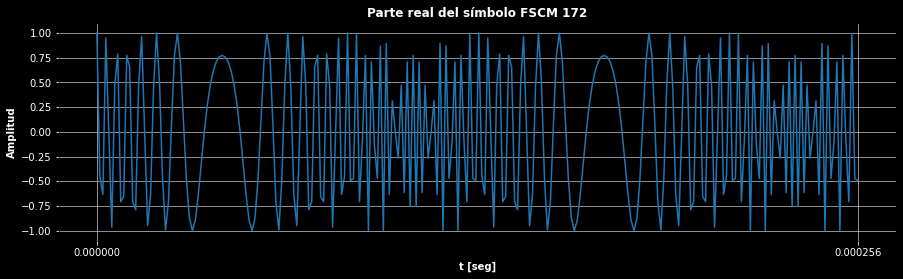

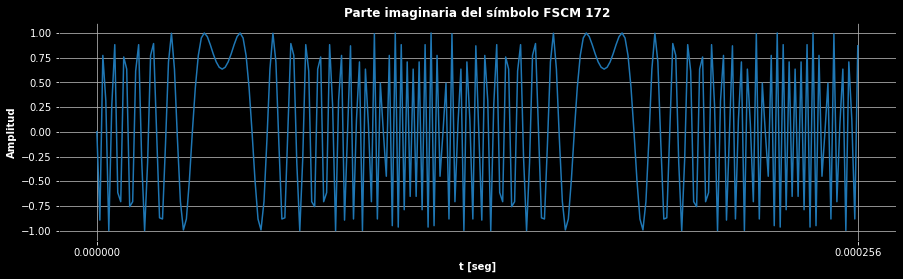

In [9]:
# Función para la generación de la onda FSCM dado un único símbolo
def single_waveform_former(symbol):
    k = np.arange(Sps)
    q = (symbol+k) % N
    chirp = (1 / np.sqrt(Sps)) * np.exp(1j * 2 * np.pi * q * k / Sps)
    time = np.linspace(0, Ts, num=Sps)

    # Normalizamos tanto la parte real como la imaginaria del chirp para que varíen entre 1 y -1, lo que permite
    # utilizar la máxima resolución del dispositivo SDR mejorando la calidad de las comunicaciones
    real_part = np.real(chirp)/np.max(np.abs(chirp.real))
    imag_part = np.imag(chirp)/np.max(np.abs(chirp.imag))
    
    return (real_part + 1j*imag_part), time

# Up chirp del símbolo 0
Base_up_chirp, _ = single_waveform_former(0)

# Generamos un símbolo LoRa y graficamos sus variaciones de amplitud y frecuencia en el tiempo.
Waveform, Time = single_waveform_former(Symbol)

plot_signal('Parte real del símbolo FSCM ' + str(Symbol), 't [seg]', 'Amplitud', Time, np.real(Waveform), cont=True)
plot_signal('Parte imaginaria del símbolo FSCM ' + str(Symbol), 't [seg]', 'Amplitud', Time, np.imag(Waveform), cont=True)

In [10]:
# Funciones para mantener el valor de las variables globales
Base_down_chirp = np.conjugate(Base_up_chirp)

# Permite cambiar el valor de SF actualizando automáticamente todos los parámetros dependientes
def set_sf(sf):
    global SF, N, Ts, Sps, Base_up_chirp, Base_down_chirp
    SF = sf
    N = 2**SF
    Ts = N*T
    Sps = Delta * N
    Base_up_chirp, _ = single_waveform_former(0)
    Base_down_chirp = np.conjugate(Base_up_chirp)


# Permite cambiar el valor de Bw actualizando automáticamente todos los parámetros dependientes
def set_bandwidth(bw):
    global Bw, Ts, T, Fs
    Bw = bw
    T = 1/Bw
    Ts = N*T
    Fs = Delta*Bw

    
def set_delta(delta):
    global Delta, Sps, Fs, Base_up_chirp, Base_down_chirp
    Delta = delta
    Sps = Delta * N
    Fs = Delta * Bw
    Base_up_chirp, _ = single_waveform_former(0)
    Base_down_chirp = np.conjugate(Base_up_chirp)


A continuación realizaremos un espectograma del chirp para observar la ya mencionada variación lineal de su frecuencia. Notesé que se produce una discontinuidad en un punto debido al módulo, dicha discontinuidad cambiará su posición según cual sea el símbolo generado, con el símbolo 0 siendo el único que no la presentará (La discontinuidad en particular se observa mejor viendo solo la parte real o imaginaría, ya que el espectograma complejo presentará otra discontinuidad por limitarse las frecuencias entre [$-Bw/2;Bw/2$]). Además la frecuencia inicial también cambiará con el símbolo.

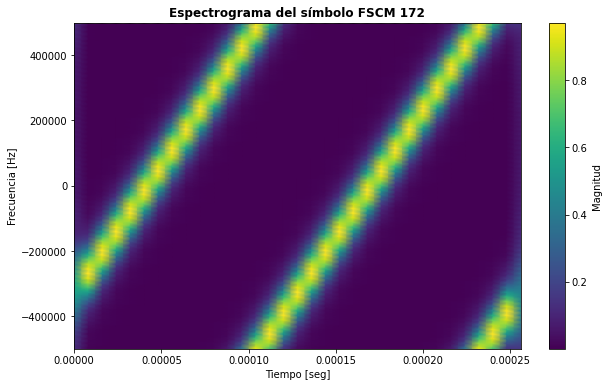

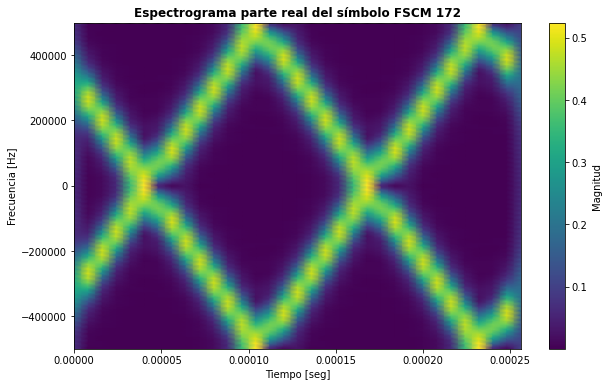

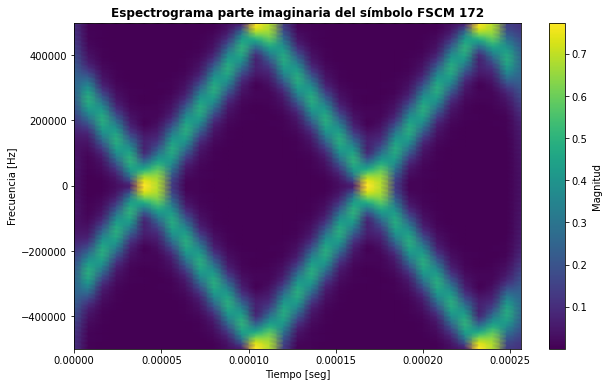

In [11]:
plot_spectrogram("Espectrograma del símbolo FSCM " + str(Symbol), Bw, Waveform, n=N)
plot_spectrogram("Espectrograma parte real del símbolo FSCM " + str(Symbol), Bw, np.real(Waveform), n=N)
plot_spectrogram("Espectrograma parte imaginaria del símbolo FSCM " + str(Symbol), Bw, np.imag(Waveform), n=N)

En la realidad no es común que querramos transmitir un único símbolo, sino que nos interesa poder concatenar múltiples símbolos para generar un paquete. A continuación se realiza el código para poder hacer eso mismo.

Hipótesis de 51 bits producida para transmitir: 

[0 0 1 1 0 0 0 1 1 1 0 1 0 0 1 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 1 0 1 1
 0 1 1 0 1 1 0 0 1 1 1 0 1 1]

Hipótesis codificada: [ 0 99 83 20 18 91 54 59]


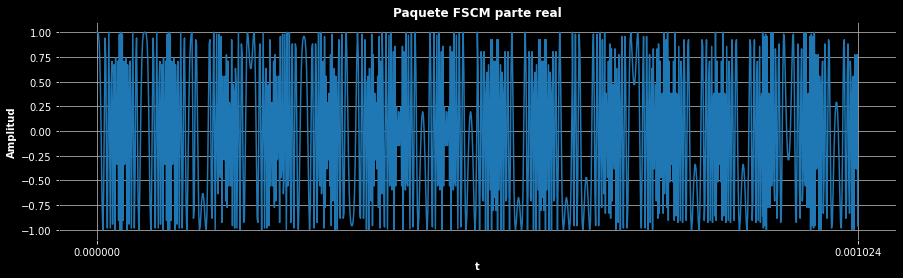

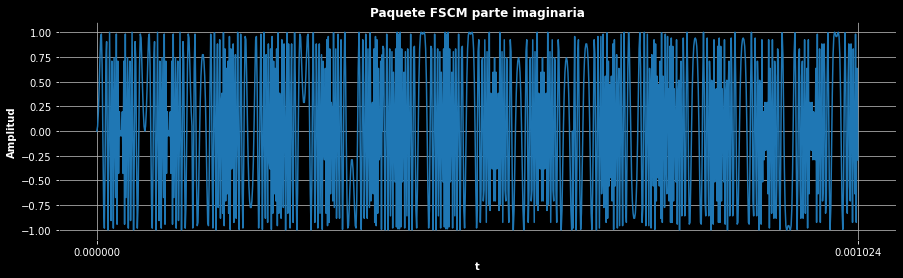

In [12]:
set_sf(7)
set_delta(1)

# Permite generar una señal de n símbolos para n mayor a 0
def multi_waveform_former(symbols):
    data = np.array([])
    time = np.array([])
    
    for sym in symbols:
        d, t = single_waveform_former(sym)
        data = np.append(data, d)
        if len(time) != 0:
            time = np.append(time, t + time[len(time) - 1])
        else:
            time = t
    return data, time


Data = hypothesis_source(random.randint(SF*4, SF*8))
Codes = encode_full_message(Data, SF)
Packet, Packet_time = multi_waveform_former([int(Codes[i]) for i in range(len(Codes))])

print('Hipótesis de ' + str(len(Data)) + ' bits producida para transmitir: \n\n' + str(Data))
print('\nHipótesis codificada: ' + str(Codes))
plot_signal('Paquete FSCM parte real', 't', 'Amplitud', Packet_time, np.real(Packet), cont=True)
plot_signal('Paquete FSCM parte imaginaria', 't', 'Amplitud', Packet_time, np.imag(Packet), cont=True)

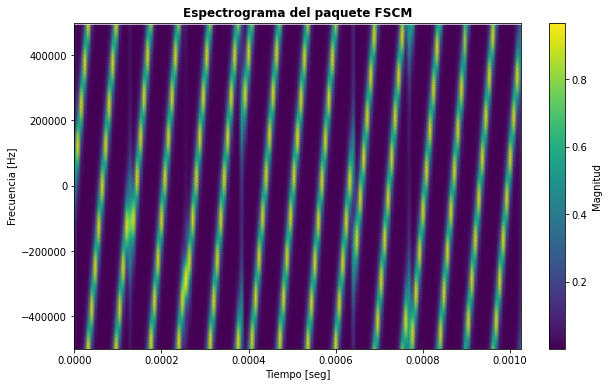

In [13]:
plot_spectrogram("Espectrograma del paquete FSCM", Bw, Packet)

# SDR

Para poder llevar nuestra simulación a casos más prácticos, realizaremos a continuación una transmisión y recepción del paquete por medio de dispositivos SDR. Por ahora la transmisión se llevará a cabo en modo loopback, es decir, en un canal ideal sin ruido.

Para realizar la transmisión se deberá asignar al dispositivo SDR una frecuencia de muestreo igual al valor programado como $Fs$ y un filtro de frecuencias mayor o igual al ancho de banda de la señal a transmitir.

Además se programa un buffer de recepción con tamaño suficiente para alvergar 3 veces la señal esperada, de este modo siempre caberá al menos una vez la señal transmitica completa sin cortes por defasajes entre la señal transmitida y el receptor.

In [14]:
#------------------------------- SDR Parameter Configuration -------------------------------
Uri                  = "ip:192.168.1.37"
sdr                  = adi.Pluto(Uri)

sdr.loopback         = 1                    # 0=Desactivado, 1=Loopback digital, 2=Retransmisión
sdr.samplingRate     = int(Fs)              # Frecuencia de muestreo para Tx y Rx [Samples/Sec]

# Filtro de frecuencia para filtrar ruido. Debe ser mayor al ancho de banda utilizado.
sdr.tx_rf_bandwidth  = int(2*Bw)            # Lo utilizamos tanto en Tx como en Rx. Puede tomar valores entre 200 KHz y 20 MHz
sdr.rx_rf_bandwidth  = int(2*Bw)

sdr.tx_hardwaregain_chan0 = -10             # Atenuación del canal de Tx, acepta valores entre -89 y 0 dB [dB]
sdr.rx_hardwaregain_chan0 = 0               # Ganancia del canal Rx. Solo válido cuando gain_control_mode es 'manual'    
sdr.gain_control_mode_chan0 = "slow_attack" # Opciones válidas: slow_attack, fast_attack, manual

sdr.tx_lo            = int(800e6)           # Frecuencia de la portadora del canal Tx [Hz] entre 325 Mhz y 3.800 Mhz
sdr.rx_lo            = int(800e6)           # Frecuencia de la portadora del canal Rx [Hz] entre 325 Mhz y 3.800 Mhz

sdr.rx_buffer_size   = len(Packet)*3        # Tamaño del buffer de recepción, debe ser mayor o igual al paquete. Max 2**28
sdr.tx_cyclic_buffer = True                 # La transmisión se hace cíclica para simular asincronismo entre Tx y Rx

A la señal a transmitir le agregamos un espacio del tamaño de 2 símbolos rellenos de ceros al final para que al recibir la señal podamos observar la diferencia entre una transmisión y la siguiente.

In [15]:

# Transmitimos la señal
sdr.tx_destroy_buffer()
sdr.rx_destroy_buffer()

sdr.rx_buffer_size   = len(Packet)*3
Message = np.append(Packet, np.zeros(Sps*2))
sdr.tx(Message*(2**14))


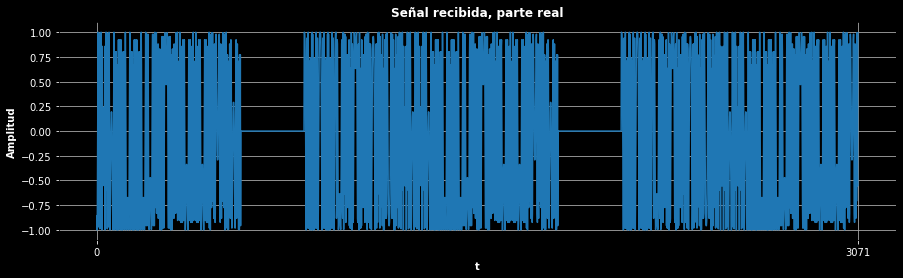

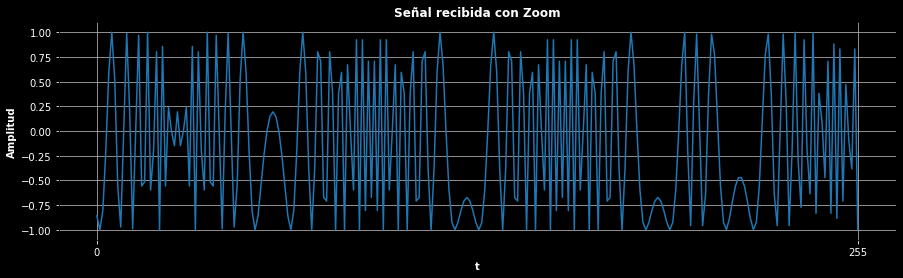

In [16]:
# Limpiamos el buffer de Rx antes de leer la señal
for i in range(10):
    discard = sdr.rx()

def receive():
    rx_signal = sdr.rx()
    
    # Normalizamos la señal recibida para seguir en el mismo rango que con la señal transmitida
    real_part = np.real(rx_signal)/np.max(np.abs(rx_signal.real))
    imag_part = np.imag(rx_signal)/np.max(np.abs(rx_signal.imag))
    return real_part + 1j*imag_part
    
Rx_signal = receive()
plot_signal('Señal recibida, parte real', 't', 'Amplitud', np.linspace(0, len(Rx_signal)-1, len(Rx_signal)), np.real(Rx_signal), cont=True)
Zoom = Rx_signal[:Sps*2]
plot_signal('Señal recibida con Zoom', 't', 'Amplitud', np.linspace(0, len(Zoom)-1, len(Zoom)), np.real(Zoom), cont=True)

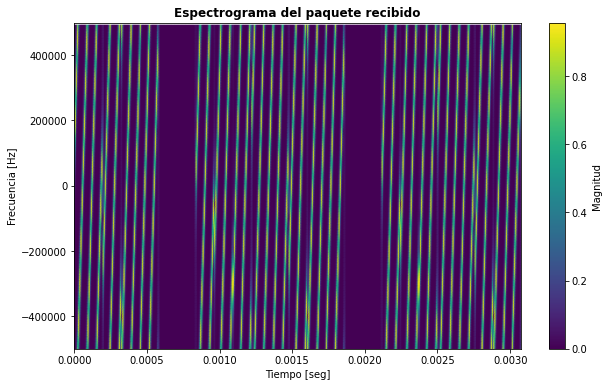

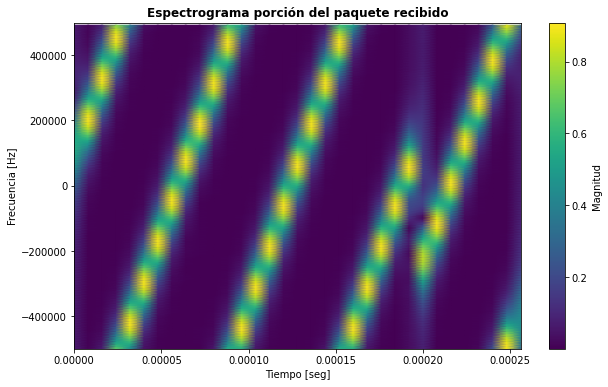

In [17]:
plot_spectrogram("Espectrograma del paquete recibido", Bw, Rx_signal)
plot_spectrogram("Espectrograma porción del paquete recibido", Bw, Zoom)


## Demodulación

Dada una observación $r(nT_s+kT)=c(nT_s+kT)+N(nT_s+kT)$ por parte del receptor, donde $c$ es la señal modulada y transmitida por el transmisor, y $N$ el ruido introducido por el canal, generalmente para que el receptor deduzca cuál fue el símbolo transmitido debe realizar una demodulación y un test de hipótesis.

En cuanto a la primera parte de este proceso la podemos realizar observando la frecuencia inicial del chirp recibido, ya que esta es proporcional al código transmitido. Pero ¿Cómo podemos medir esta frecuencia inicial? Para obtener la respuesta primero tenemos que dejar una propiedad de nuestros símbolos en claro, y es que dados 2 símbolos $c_i, c_j$ tales que $i \neq j$ los mismos son ortogonales entre sí, es decir:

$$\left<c(nT_s + kT)_{s(nT_s)=i},c^*(nT_s + kT)_{s(nT_s)=j}\right> = 0$$

La forma más simple de demodulación y testeo de hipótesis es entonces proyectar la observación $r(nT_s + kT)$ con cada posible símbolo $c(nT_s + kT)$ y luego obtener el módulo cuadrado de cada uno de estos. En ausencia de ruido todos los símbolos erróneos se cancelarían, de modo que podremos recuperar el símbolo realizando $2^{SF}$ proyecciones. El problema con esta solución es el peso computacional alto que requeriría su implementación, en su lugar se presenta a continuación un método mucho más eficiente de realizar este proceso.

Iniciamos por realizar la proyección previamente mencionada en términos generales:

$$\left<r(nT_s + kT),c^*(nT_s + kT)_{s(nT_s)=i}\right>$$
$$\frac{1}{\sqrt{\delta2^{SF}}}\sum_{k=0}^{2^{SF}-1}r(nT_s + kT)e^{-j2\pi [|i+k|_{mod 2^{SF}}] \frac{k}{\delta2^{SF}}}$$
$$\frac{1}{\sqrt{\delta2^{SF}}}\sum_{k=0}^{2^{SF}-1}r(nT_s + kT)e^{-j2\pi\frac{k^2}{\delta2^{SF}}}e^{-j2\pi + [|i+k|_{mod 2^{SF}}] - k \frac{k}{\delta2^{SF}}}$$

Enfocándonos en la última exponencial observamos que para $s+k<2^{SF}$ tenemos:

$$e^{-j2\pi (s(i)+k-k) \frac{k}{\delta2^{SF}}}=e^{-j2\pi\frac{ik}{\delta2^{SF}}}$$

Y similarmente para $s+k\geq 2^{SF}$:

$$e^{-j2\pi (i+k-k-2^{SF}) \frac{k}{\delta2^{SF}}} = e^{-j2\pi\frac{ik}{\delta2^{SF}}} e^{j2k\frac{\pi}{\delta}}$$
$$=e^{-j2\pi\frac{ik}{\delta2^{SF}}}$$

Con lo que podemos reescribir nuestra proyección como:

$$\left<r(nT_s + kT),c^*(nT_s + kT)_{s(nT_s)=i}\right>=\frac{1}{\sqrt{\delta2^{SF}}}\sum_{k=0}^{2^{SF}-1}r(nT_s + kT)e^{-j2\pi\frac{k^2}{\delta2^{SF}}}e^{-j2\pi\frac{ik}{\delta2^{SF}}}$$

Definiendo $d(nT_s + kT) = r(nT_s + kT)e^{-j2\pi\frac{k^2}{\delta2^{SF}}}$ podemos observar que la proyección equivale a calcular la transformada discreta de fourier de $d(nT_s + kT)$:

$$\frac{1}{\sqrt{\delta2^{SF}}}\sum_{k=0}^{2^{SF}-1}d(nT_s + kT)e^{-j2\pi\frac{ik}{\delta2^{SF}}}$$

Descomponiendo $d(nT_s+kT)$ podemos observar:

$$d(nT_s+kT)=(c(nT_s+kT)+N(nT_s+kT))e^{-j2\pi\frac{k^2}{\delta2^{SF}}}$$

$$d(nT_s+kT)=\frac{1}{\sqrt{\delta2^{SF}}}e^{j2\pi|s(nT_s)+k|_{2^{SF}}\frac{k}{\delta2^{SF}}}e^{-j2\pi\frac{k^2}{\delta2^{SF}}} + N(nT_s + kT)e^{-j2\pi\frac{k^2}{\delta2^{SF}}}$$

$$d(nT_s+kT)=\frac{1}{\sqrt{\delta2^{SF}}}e^{j2\pi s(nT_s)\frac{k}{\delta2^{SF}}} + N(nT_s + kT)e^{-j2\pi\frac{k^2}{\delta2^{SF}}}$$

Lo que en un canal ideal sin ruido podemos observar que es una señal periódica de frecuencia $s(nT_s)\frac{Bw}{2^{SF}}=f_i$, con lo que su transformada de fourier presentará un impulso unitario en la frecuencia $f_i$ y 0 en todas las demás frecuencias, recuperando así nuestro mensaje inicial. Notando que la exponencial $e^{-j2\pi\frac{k^2}{\delta2^{SF}}}$ es un **down-chirp** que se forma con la conjugada del **up-chirp** base, podemos definir al proceso de **dechirpeado** como el producto entre un símbolo FSCM y el down-chirp base, siendo este proceso el que nos permitirá obtener una señal periódica con frecuencia igual a la frecuencia inicial determinada por el símbolo transmitido.

En el caso de haber sobremuestreado (Como es nuestro caso) el impulso en frecuencia se verá 2 veces, una en $f_i$ y otra en $(\delta-1)Bw + f_i$, de las cuales una presentará más energía que la otra, lo que será dependiente del símbolo. Para corregir esto se realiza un proceso llamado **Coarse-grained Phase Allignment** (CPA) que consiste simplemente en ubicar estos impulsos y reordenarlos en el espectro real, de modo que ambos se superpondrán.

El símbolo transmitido fue: 27


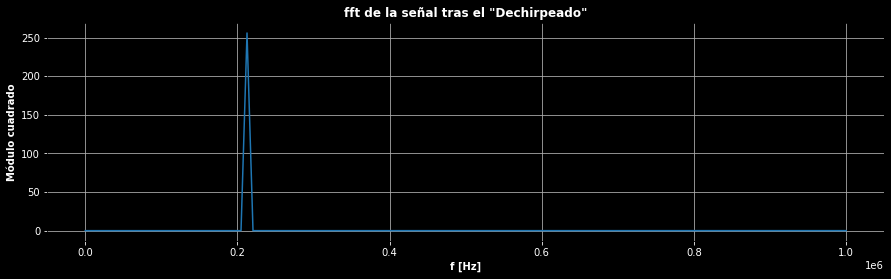

El símbolo recibido fue: 27


In [18]:
# Generadora del down-chirp base
Base_down_chirp = np.conjugate(Base_up_chirp)


def dem_symbol(symbol):
    # Realizamos el proceso de "dechirpeado"
    dechirped_symbol = symbol * Base_down_chirp
    
    # Calculamos la DTF del símbolo
    symbol_fft = np.fft.fft(dechirped_symbol)
    #symbol_fft = np.fft.fftshift(np.fft.fft(dechirped_symbol))
    
    cpa = np.abs(symbol_fft[:int(len(symbol_fft)/Delta)]) + np.abs(symbol_fft[int(len(symbol_fft) - len(symbol_fft)/Delta):])
    
    # La frecuencia de mayor módulo se corresponde al símbolo particular transmitido.
    # Al haber 2^SF valores discretos de frecuencia su posición relativa en el arreglo es igual al símbolo.
    sufficient_observation = np.argmax(cpa)
    
    # Retorna la DTF, el eje de frecuencia para la DTF y un vector (símbolo demodulado, pótencia de la fft en la frecuencia correspondiente al símbolo)
    return cpa, np.linspace(0, Bw, len(cpa)), int(sufficient_observation)


# Genero un nuevo símbolo aleatorio
Code = encoder(hypothesis_source(SF))

# Genero la forma de onda correspondiente al símbolo
Symbol, _= single_waveform_former(Code)
print ('El símbolo transmitido fue: ' + str(Code))

# Demodulo el símbolo
Dem_symbol, Dem_symbol_frequencies, Rx_symbol = dem_symbol(Symbol)
plot_signal('fft de la señal tras el "Dechirpeado"', 'f [Hz]', 'Módulo cuadrado', Dem_symbol_frequencies, np.real(Dem_symbol), ticks=True, cont=True)
print ('El símbolo recibido fue: ' + str(Rx_symbol))

## Paquete LoRa:

El paquete LoRa es la política de "hand holding" entre el transmisor y el receptor de un sistema de comunicaciones LoRaWAN, y permite entre otras cosas que el receptor sepa cuando se inicia una transmisión y evitar así que decodifique ruido.

El paquete LoRa puede ser **explícito** o **implícito** donde el primero se usa para paquetes de datos de tamaño variable y el segundo es para tamaño fijo. El paquete, sea cual sea el modo elegido consiste de 3 partes:

- Preámbulo
- Start Frame Delimiter (SFD)
- Datos

El **Preámbulo** consiste en enviar un número predefinido de up-chirps base. El objetivo es que el receptor al decodificar un número específico alto de up-chirps sabrá que se está transmitiendo un paquete y que no es ruido, por ello el número de up-chirps debe ser lo suficientemente alto de modo que los datos no tiendan a contener patrones de este tipo. Luego de estos se transmiten 2 up-chirps modulados que indican el tamaño del mensaje transmitido, permitiendo así sincronizar el frame entre transmisor y receptor, esto último queda claro que solo se utiliza en casos donde el tamaño del paquete es desconocido para el receptor, es decir, transmisión explícita.

El **SFD** en algunos estudios se lo suele considerar parte del preámbulo y consiste de 2 down-chirps indicando el inicio de los datos, Esto es necesario, ya que se puede dar que el primer dato transmitido sea el mismo símbolo que el preámbulo siendo así imposible para el receptor diferenciarlo a menos que lleve la cuenta exacta del preámbulo sin haberse perdido ninguna lectura por ruido.

Datos empaquetados: [  4  64 123   6  42  94  92]


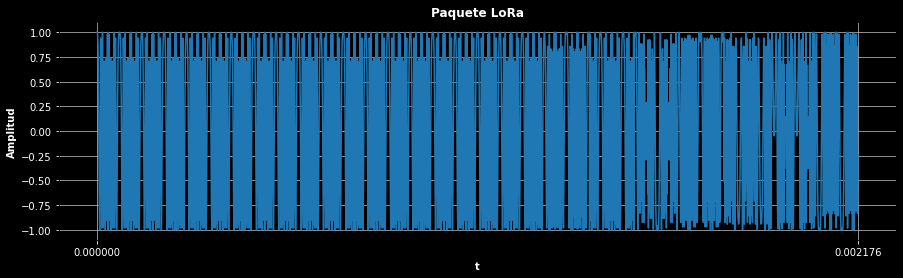

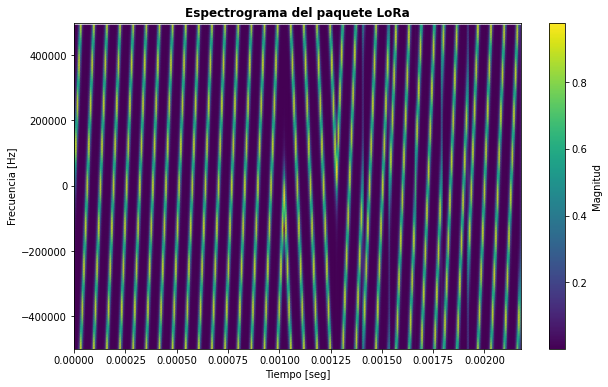

In [19]:
Preamble = []
Preamble_conj = []

set_sf(7)
def build_preamble(size):
    # Genero un up-chirp base para el preámbulo
    c, t = single_waveform_former(0)
    aux_t = t
    
    # Añado al preámbulo el número deseado de up-chirps base
    for i in range(size - 1):
        c = np.append(c, Base_up_chirp)
        t = np.append(t, aux_t + t[len(t) - 1])
    
    # Añado los 2 down-chirps de la SFD 
    for i in range(2):
        c = np.append(c, Base_down_chirp)
        t = np.append(t, aux_t + t[len(t) - 1])
    return c, t


# Genera un paquete LoRa con preámbulo y SFD a partir de los símbolos codificados
def build_packet(symbols, preamble_size):
    global Base_down_chirp, Base_up_chirp, Preamble, Preamble_conj
    Base_up_chirp, _ = single_waveform_former(0)
    Base_down_chirp = np.conjugate(Base_up_chirp)
    # Genera el preámbulo + SFD
    data, time = build_preamble(preamble_size)
    Preamble = data
    Preamble_conj = np.conjugate(Preamble)
    # Modula los símbolos
    d, t = multi_waveform_former(symbols)
    # Coloco los símbolos inmediatamente después del preámbulo
    data = np.append(data, d)
    time = np.append(time, t+time[-1])
    return data, time


# Genero los datos y los codifico
Data = hypothesis_source(random.randint(SF*4, SF*8))
Codes = encode_full_message(Data, SF)
Data_length = len(Codes)

# Genero el paquete con un preámbulo de 4 up-chirps base
Preamble_size = 8
Lora_packet, LoRa_pack_time = build_packet(Codes, Preamble_size)

print('Datos empaquetados: ' + str(Codes))
plot_signal('Paquete LoRa', 't', 'Amplitud', LoRa_pack_time, np.real(Lora_packet), cont=True)
plot_spectrogram("Espectrograma del paquete LoRa", Bw, Lora_packet)

### Demodulación de paquete

En un principio la demodulación de un paquete LoRa se puede llevar a cabo de la misma manera en que se demodulaba un símbolo, pero hay que tener en cuenta 2 pasos extra:

- Separar el preámbulo de los datos
- Asegurar que la lectura está en fase con la transmisión

Para el primero es para lo que existe el SFD, ya que idealmente, al demodular con un down-chirp todos los símbolos tendrán una frecuencia constante que se observará tras realizar la fft, pero el down-chirp, al tener una naturaleza opuesta, presenta esta propiedad con un up-chirp. Así idealmente bastaría con realizar el producto de cada símbolo con un down-chirp, y aquellos que no presenten un impulso unitario en frecuencia serán el SFD, con lo que le procederán los datos.

En un canal real el ruido distorsiona la frecuencia de modo que ningún símbolo se recibirá como un up-chirp ideal, y su frecuencia se verá alterada como ya se discutió previamente, aun así es posible estimar si el símbolo es un up-chirp o un down-chirp realizando una correlación.

In [20]:
def dem_multiple_waves(waves):
    data_length = int(len(waves)/Sps)
    waves_ffts = []
    waves_observations = []
    
    for i in range(data_length):
        # Tomamos una porción del paquete de tamaño proporcional a un solo símbolo
        wave = waves[i*Sps: (i + 1)*Sps]

        # Demodulamos los símbolos uno por uno
        aux_fft, _, aux_observations = dem_symbol(wave)

        # Guardamos los valores demodulados
        waves_ffts.append(aux_fft)
        waves_observations.append(aux_observations % N)
        
    # Retornamos las ffts de los símbolos dechirpeados, el eje de las frecuencias y los símbolos demodulados 
    return np.asarray(waves_ffts), np.linspace(0, Bw, len(waves_ffts[0])), np.asarray(waves_observations)

Por otra parte, también debemos asegurar que el receptor esté en fase con el transmisor, para ello el preámbulo cumple un papel fundamental. Inicialmente, desde el preámbulo se transmite el símbolo 0 multiples veces, pero si la lectura se hace fuera de fase el símbolo que se obtendrá cambiará, observando como se ve el símbolo 0 (up-chirp base) al desfasarse, teniendo el mismo otro up-chirp base delante de él, este se demodulará como un símbolo distinto a 0, y lo mismo ocurrirá con el siguiente, y el siguiente hasta finalizar el preámbulo. De este modo el receptor ideal, al notar que recibió multiples veces el mismo símbolo, incluso si este no es un 0, puede saber que la transmisión se inició, y el símbolo que logra leer le indica cuan desfasado se encuentra del transmisor, luego al recibir un símbolo diferente comprobará si se trata de un down-chirp, en cuyo caso considerará que a continuación vendrá el mensaje.

En el caso de transmisión continua debemos asegurar que el mensaje completo cabe en una sola lectura, ya que si este se corta entre múltiples recepciones, aunque en teoría sería posible reconstruirlo, existirá un defasaje entre recepciones debido a las limitaciones de velocidad del hardware, por lo que en su lugar se trabaja con un buffer de recepción de tamaño tal que pueda almacenar 3 veces la señal transmitida, de este modo se asegura que se encontrará al menos una vez completa.

Para nuestro caso espécifico simplificaremos el problema aprobechando que la señal se transmite de forma repetitiva, con lo que bastará que el receptor realice una correlación entre la señal recibida y el preámbulo para verificar su precencia y desfase, y así encontrar la porción de datos.

Datos empaquetados: [  4  64 123   6  42  94  92]
Se encontró la porción de datos completa:


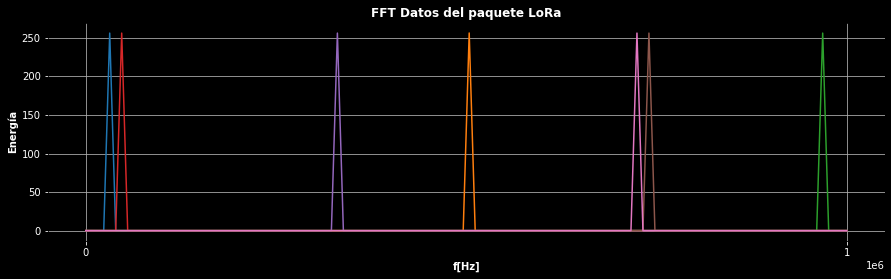

Datos demodulados: [  4  64 123   6  42  94  92]


In [21]:

def dem_packet(signal):
    # 1. Detectamos el preámbulo por correlación
    corr = np.abs(np.correlate(signal, Preamble, mode='same'))
    preamble_pos = np.argmax(corr)
    
    # 1.1 Si no tiene espacio suficiente para los datos retornar
    if not len(signal[int(preamble_pos + len(Preamble)//2):]) >= Data_length*Sps:
        return False, [], [], []
    
    data = signal[int(preamble_pos + len(Preamble)//2):]
    
    # Demodulamos los datos
    a, b, c = dem_multiple_waves(data[:Data_length*Sps])
    return True, a, b, c


Is_full, FFT, Freq, OBS = dem_packet(Lora_packet)
print('Datos empaquetados: ' + str(Codes))
if Is_full:
    print('Se encontró la porción de datos completa:')
    plot_signal('FFT Datos del paquete LoRa', 'f[Hz]', 'Energía', Freq, *FFT, cont=True)
    print(f'Datos demodulados: {OBS}')

Para acercarnos más al caso real creamos una función simple que agregará ruido AWGN a la señal simulada y así comprobaremos la capacidad de demodular la misma que tiene nuestra función. 

Datos empaquetados: [  4  64 123   6  42  94  92]
Se encontró la porción de datos completa:


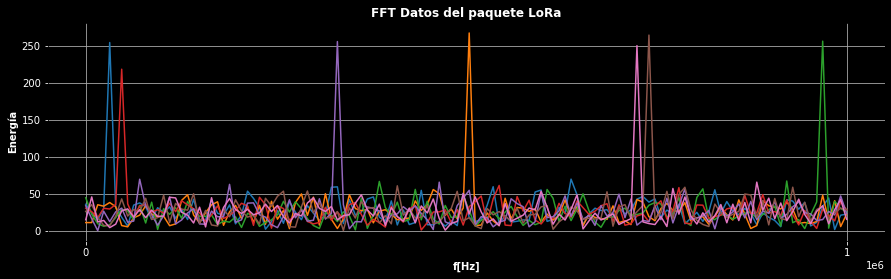

Datos demodulados: [  4  64 123   6  42  94  92]


In [22]:
def awgn_channel(signal, snr_db):
    signal_power = np.mean(np.abs(signal)**2)
    snr_lineal = 10**(snr_db / 10)
    noise_power = signal_power / snr_lineal
    sigma = np.sqrt(noise_power / 2)
    real_noise = np.random.normal(0, sigma, len(signal))
    imag_noise = np.random.normal(0, sigma, len(signal))    
    noise = real_noise + 1j * imag_noise
    return signal + noise

Is_full, FFT, Freq, OBS = dem_packet(awgn_channel(Lora_packet, -2))
print('Datos empaquetados: ' + str(Codes))
if Is_full:
    print('Se encontró la porción de datos completa:')
    plot_signal('FFT Datos del paquete LoRa', 'f[Hz]', 'Energía', Freq, *FFT, cont=True)
    print(f'Datos demodulados: {OBS}')

Ahora, para acercarnos más al caso real realizamos una tranmisión con el dispositivo SDR. En esta primera simulación eliminaremos el ruido ya que lo que buscamos en este caso es testear la configuración del SDR y la capacidad de nuestra función para detectar y demodular señales defasadas de forma experimental.

In [23]:
sdr.tx_destroy_buffer()
sdr.rx_destroy_buffer()
sdr.loopback = 1

# Cambiamos el buffer de recepción para que pueda contener 3 veces la señal transmitida
sdr.rx_buffer_size   = len(Lora_packet)*3

# Transmitimos la señal
sdr.tx(np.append(Lora_packet, np.zeros(Sps*2))*(2**14))

Datos empaquetados: [  4  64 123   6  42  94  92]
Resuelto


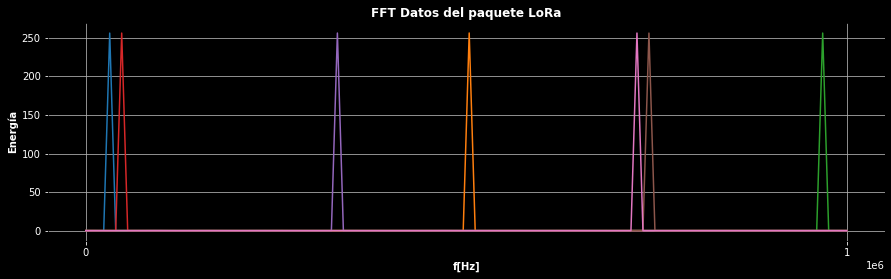

Datos demodulados: [  4  64 123   6  42  94  92]


In [24]:
# Esperamos a que se vacie el buffer de transmisor anterior
for _ in range(10):
    sdr.rx()

# Se recibirá continuamente hasta que el demodulador encuentre algo que considere que sean los datos
for _ in range(10):
    Rx_signal = receive()
    Is_done, FFT, Freq, OBS = dem_packet(Rx_signal)
    # Al encontrar los datos salimos del loop
    if Is_done:
        print('Datos empaquetados: ' + str(Codes))
        print('Resuelto')
        plot_signal('FFT Datos del paquete LoRa', 'f[Hz]', 'Energía', Freq, *FFT, cont=True)
        print(f'Datos demodulados: {OBS}')
        break

Por último falta testear nuestro sistema en un caso que contenga tanto la transmisión real por SDR como la precesncia de ruido AWGN. Para ello realizamos una transmisión con el modo Loopback del SDR desactivado, permitiendo realizar la transmisión por aire.

Cabe aclarar que para realizar una transmisión por aire que presente una cantidad significativa de ruido lo mejor es bajar el nivel de ganancia que el SDR aplicará en la transmisión de la señal, reduciendo el valor de la SNR.

In [25]:
sdr.tx_destroy_buffer()
sdr.rx_destroy_buffer()

# Cambiamos el modo loopback a desactivado para transmisión por aire
sdr.loopback = 0
# Bajamos al ganancia de transmisión para poder observar valores apreciables de ruido
sdr.tx_hardwaregain_chan0 = -30#-70

# Transmitimos la señal
sdr.rx_buffer_size   = len(Lora_packet)*3
sdr.tx(np.append(Lora_packet, np.zeros(Sps*2))*(2**14))

Datos empaquetados: [  4  64 123   6  42  94  92]
Resuelto


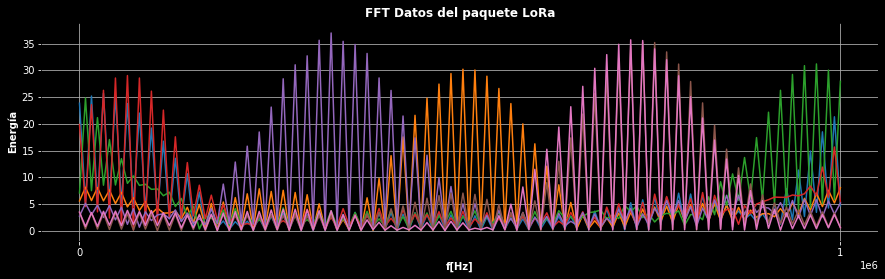

Datos demodulados: [  4  64 123   8  42  94  92]


In [26]:
# Esperamos a que se vacie el buffer de transmisor anterior
for _ in range(10):
    sdr.rx()
    
while(True):
    Rx_signal = receive()
    Is_done, FFT, Freq, OBS = dem_packet(Rx_signal)
    if Is_done:
        print('Datos empaquetados: ' + str(Codes))
        print('Resuelto')
        plot_signal('FFT Datos del paquete LoRa', 'f[Hz]', 'Energía', Freq, *FFT, cont=True)
        print(f'Datos demodulados: {OBS}')
        break

# Decodificar a bits

In [27]:
def multi_symbol_decoder(symbols):
    return np.array([list(np.binary_repr(symbol, width=SF)) for symbol in symbols], dtype=int).flatten()

       
print(multi_symbol_decoder([52, 23, 0, 3]))

[0 1 1 0 1 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1]


# Curva de BER

A continuación se realiza una simulación de Monte Carlo para obtener curvas de BER de nuestro sistema. Las mismas se generan por simulación haciendo variar la SNR por varios valores conocidos, mientras que el SF se mantiene fijo (El valor que se utilizó en este caso fué SF = 6). La simulación se ejecutó 2 veces, una con delta igual a 1 y otra con delta igual a 2, se observa un mayor error en el segundo caso, esto se debe probablemente a el ancho mayor de los lobulos que produce la convinación del uso de la fft y el sobre-muestréo, que no son corregidos al realizar CPA, mientras que con delta igual a 1 solo se tiene un impulso en frecuencia por lo que se necesitará un mayor ruido para producir el ruido. Ante esto queda claro que para poder aplicar un sobre-muestreo (técnica que es necesaria para corregir el offset de fase producido en comunicaciones reales) se requiere alguna técnica que permita eliminar el ancho de los mencionados lóbulos.

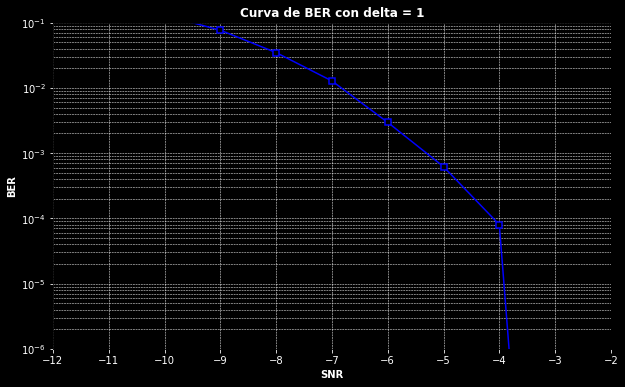

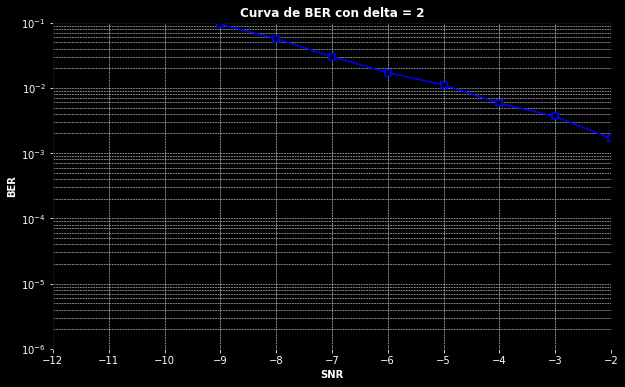

In [28]:
SNR_Axis = [i-12 for i in range(11)]

set_sf(6)


def LoRa_Simulation(bits, snr_db):
    global Data_length
    # Generar la hipótesis
    data_bits = hypothesis_source(bits)
    
    # Codificar bits
    codes = encode_full_message(data_bits, SF)
    Data_length = len(codes)
    
    # Modular los símbolos
    waveform, _ = build_packet(codes, Preamble_size)
    
    # Agregar ruido por simulación
    noisy_waveform = awgn_channel(waveform, snr_db)
    
    # Demodular la señal
    _, _, _, received_codes = dem_packet(noisy_waveform)
    
    # Decodificar a bits
    decoded_data = multi_symbol_decoder(received_codes)
    
    if len(decoded_data) == 0:
        return -1
    
    # Ajustar longitud de los datos para coincidir con decoded_data
    if len(decoded_data) > len(data_bits):
        padding = len(decoded_data) - len(data_bits)
        data_bits = np.pad(data_bits, (padding, 0), 'constant', constant_values=0)

    # Contar errores
    errors = np.sum(np.array(data_bits).flatten() != np.array(decoded_data).flatten())
    
    # Calcular BER
    total_bits = data_bits.size
    ber = errors / float(total_bits)
    
    return round(ber, 10)


def get_ber_sim(bits=50000, iterations=1):
    global Data_length
    
    ber_values = np.zeros(len(SNR_Axis))
    
    for i in range(len(SNR_Axis)):
        ber_sum = 0  # Acumulador para el BER de cada iteración
        for _ in range(iterations):
            ber = LoRa_Simulation(bits, SNR_Axis[i])
            while ber == -1:
                ber = LoRa_Simulation(bits, SNR_Axis[i])
            ber_sum += ber
        ber_values[i] = ber_sum / iterations  # Promedio de BER para el SNR actual
    
    ber_values[ber_values == 0] = 1e-15
    
    return ber_values


BER_Axis = get_ber_sim()
plot_ber('Curva de BER con delta = 1', SNR_Axis, BER_Axis)

set_delta(2)
BER_Axis = get_ber_sim()
plot_ber('Curva de BER con delta = 2', SNR_Axis, BER_Axis)

# Calculo BER x SDR    

A continuación hacemos una simulación de Monte Carlo para calcular el valor del BER esperado para comunicaciónes por aire, la misma fue ejecutada con los valores que se acarrearon de la simulación anterior para SF y $\delta$, es decir $SF=6$ y $\delta = 2$. 


In [29]:
set_delta(2)
# Considerar que el máximo tamaño del buffer de Rx es 2**20, por lo que bits debe ser tal que quepa todo el mensaje tres veces en ese buffer
def LoRa_Tx_BER(bits):
    global Data_length
    # Generar la hipótesis
    data_bits = hypothesis_source(bits)
    
    # Codificar bits
    codes = encode_full_message(data_bits, SF)
    Data_length = len(codes)
    
    # Modular los símbolos
    waveform, _ = build_packet(codes, Preamble_size)
    
    # Transmitir la señal modulada
    sdr.tx_destroy_buffer()
    sdr.rx_destroy_buffer()
    sdr.loopback = 0
    sdr.tx_hardwaregain_chan0 = -30
    sdr.rx_buffer_size   = len(waveform)*3

    sdr.tx(np.append(waveform, np.zeros(Sps*2))*(2**14))

    # Vaciar buffer de recepción
    for _ in range(10):
        sdr.rx()

    # Recibir la señal
    while(True):
        rx_signal = receive()
        is_done, _, _, obs = dem_packet(rx_signal)
        if is_done:
            break
    
    # Demodular la señal
    _, _, _, received_codes = dem_packet(rx_signal)
    
    # Decodificar a bits
    decoded_data = multi_symbol_decoder(received_codes)
    
    if len(decoded_data) == 0:
        return -1
    
    # Ajustar longitud de los datos para coincidir con decoded_data
    if len(decoded_data) > len(data_bits):
        padding = len(decoded_data) - len(data_bits)
        data_bits = np.pad(data_bits, (padding, 0), 'constant', constant_values=0)

    # Contar errores
    errors = np.sum(np.array(data_bits).flatten() != np.array(decoded_data).flatten())
    
    # Calcular BER
    total_bits = data_bits.size
    ber = errors / float(total_bits)
    
    return round(ber, 10)

Iterations = 5
BER = 0
for _ in range(Iterations):
    BER += LoRa_Tx_BER(10000)
BER /= Iterations
print(f"La señar se decodificó con un BER de {BER}")


La señar se decodificó con un BER de 0.26360727854


Para confirmar que el valor obtenido tiene sentido con los valores de la gráfica generada calculamos rápidamente la SNR de nuestra transmisión por aire.

In [31]:
# Genero los datos y los codifico
Data = hypothesis_source(100)
Codes = encode_full_message(Data, SF)
Data_length = len(Codes)

# Genero el paquete
Lora_packet, _ = build_packet(Codes, Preamble_size)

# Leo ruido del aire
sdr.tx_destroy_buffer()
sdr.rx_destroy_buffer()
sdr.tx_lo            = int(650e6)
sdr.rx_buffer_size = len(Lora_packet)
for _ in range(10):
    sdr.rx()
Noise = sdr.rx()

# Calculo SNR
Noise_power = np.mean(np.abs(Noise)**2)
# La potencia de la señal como se transmite (*2**14 y con ganancia de -70 db)
Signal_power = np.mean(np.abs(Lora_packet*(2**14))**2)/(10**(7))
SNR = 10*np.log10(Signal_power/Noise_power)

print(f'SNR medida para la señal a transmitir: {SNR}')

SNR medida para la señal a transmitir: -27.137876460109098


In [32]:
# Tx no puede desactivarse, por ello lo configuramos para que transmita a baja potencia y con una frecuencia distinta a Rx
sdr.tx_destroy_buffer()
sdr.tx_hardwaregain_chan0  = -70
sdr.rx_lo                  = int(2400e6)
sdr.tx(np.zeros(1024))
# Destruimos el objeto sdr
del(sdr)